<a href="https://colab.research.google.com/github/DR-MaiElbadwey/FExGAN/blob/master/FExGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explore the Expression: Facial Expression Generation using Auxiliary Classifier Generative Adversarial Network

In [ ]:
import tensorflow as tf

import os
import time
from os import path
from matplotlib import pyplot as plt

from Generator import makeGenerator
from Discriminator import makeDiscriminator
import datetime
import numpy as np
import pathlib
import random

## Loading and Preparing Data

In [ ]:
data_path = pathlib.Path("G:\Datasets\FERG_256")
ids = np.array(sorted([item.name for item in data_path.glob('*')]) )
affects = np.array(sorted([item.name for item in data_path.glob('aia/*')]) )

EPOCHS = 50
BUFFER_SIZE = 14224
BATCH_SIZE = 32
IMG_WIDTH = 128
IMG_HEIGHT = 128


def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_png(image,channels=3)
    image = tf.cast(image, tf.float32)

    path_strs = tf.strings.split(image_file, os.path.sep)
    one_hot_affect = path_strs[-2] == affects
    one_hot_char_id = path_strs[-3] == ids
    affect_indx = tf.argmax(one_hot_affect)
    char_id_indx = tf.argmax(one_hot_char_id)
    label = [affect_indx,char_id_indx]

    return image, label



def normalize(image):
    image = (image / 127.5) - 1
    return image

def resize(image):
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image

def load_images(image_file):
    image, label = load(image_file)
    image = resize(image)
    image = normalize(image)
    return image, label

def prepare_dataset():

    dataset = tf.data.Dataset.list_files(str(data_path/'*/*/*'))
    # split the data into train and validation sets
    image_count = len(list(dataset))
    print("Total_images:"+str(image_count))
    val_size = int(image_count * 0.2)
    train_ds = dataset.skip(val_size)
    val_ds = dataset.take(val_size)
    print("Training_images:"+str(len(list(train_ds))))
    print("Validation images:"+str(len(list(val_ds))))
    train_ds = train_ds.map(load_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_ds = train_ds.batch(BATCH_SIZE)

    val_ds = val_ds.map(load_images)
    val_ds = val_ds.batch(BATCH_SIZE)

    return train_ds,val_ds

In [ ]:
train_ds,val_ds = prepare_dataset()

Total_images:55766
Training_images:44613
Validation images:11153


## Viewing Images

In [ ]:
import numpy as np

def view_images(images,labels,nr_imgs,row,col):

    fig = plt.figure(figsize=(3*col,2*row))

    for i in range(nr_imgs):
        ax = fig.add_subplot(row, col, i+1)
        ax.imshow(images[i] * 0.5 + 0.5)
        ax.title.set_text(affects[labels[i][0]])
        ax.axis('off')


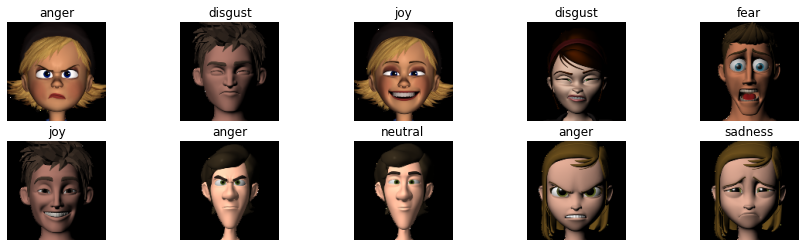

In [ ]:
for img_batch, labels in val_ds.take(1):
    view_images(img_batch,labels,10,2,5)

## Saving reference images for ID verification

In [ ]:
#ref_images = tf.Variable(tf.zeros(shape=[len(ids),len(affects),IMG_WIDTH,IMG_HEIGHT,3],dtype=tf.float32))
ref_images = [[[] for j in range(len(affects))] for i in range(len(ids))]

count = 0
has_filled = False



for img_batch, labels in val_ds:
    for img,lbl in zip(img_batch,labels):
        affect_idx = lbl[0].numpy()
        char_idx = lbl[1].numpy()
        '''if(has_filled==False):
            ref_img = ref_images[char_idx,affect_idx,:,:,:]
            if(tf.reduce_sum(ref_img)==0):
                ref_images[char_idx,affect_idx,:,:,:].assign(img)  #saving sample references for later use
                count = count + 1
            if(count>=42):
                has_filled = True
        '''
        ref_images[char_idx][affect_idx].append(img)
    #if(has_filled):
    #    break;


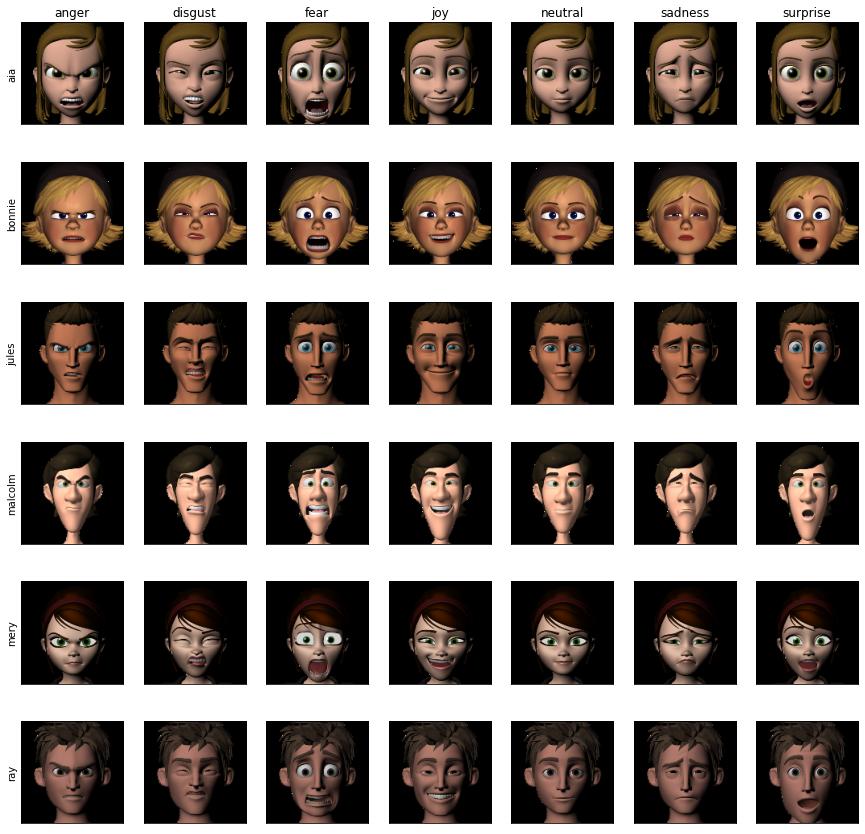

In [ ]:
fig = plt.figure(figsize=(15,15))
for r in range(6):
    for c in range(7):
        imgs=ref_images[r][c]
        idx =random.randint(0,len(ref_images[r][c])-1)
        img = imgs[idx]*0.5+0.5
        #img = ref_images[r,c,:,:,:]*0.5+0.5
        ax = fig.add_subplot(6,7,7*r+c+1)
        ax.imshow(img)
        ax.set_yticks([])
        ax.set_xticks([])
        if(r==0):
            ax.set_title(affects[c])
        if(c==0):
            ax.set_ylabel(ids[r])

## Building Model

In [ ]:
Reload = True

generator,encoder,decoder = makeGenerator()
discriminator = makeDiscriminator()

encoder.summary()
decoder.summary()
generator.summary()

discriminator.summary()

if(Reload==True):
    encoder.load_weights('encoder_weights.h5')
    decoder.load_weights('decoder_weights.h5')
    generator.load_weights('generator_weights.h5')
    discriminator.load_weights('discriminator_weights.h5')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
label_input (InputLayer)        [(None, 7)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16384)        131072      label_input[0][0]                
__________________________________________________________________________________________________
img_input (InputLayer)          [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 128, 128, 1)  0           dense[0][0]                      
______________________________________________________________________________________________

## Objective Function

In [ ]:
Alpha = 0.8
Beta = 0.2
Gamma = 5
loss_object_binary = tf.keras.losses.BinaryCrossentropy()
loss_object_multi = tf.keras.losses.CategoricalCrossentropy()



def generator_loss(reference_imgs,disc_fake_y,disc_fake_class, fake_output, fake_labels,mu,sigma):

    gan_loss1 = loss_object_binary(tf.ones_like(disc_fake_y), disc_fake_y)
    gan_loss2 = loss_object_multi(fake_labels, disc_fake_class)

    # KL divergence loss
    kl_loss = -0.5 * tf.reduce_mean(1 + sigma - tf.square(mu) - tf.exp(sigma))

    gan_loss = 0.02 * gan_loss1 + gan_loss2

    l1_loss = tf.reduce_mean(tf.abs(fake_output - reference_imgs))  # identity of the generated images should be same with different emotion

    gen_loss = Alpha * gan_loss +  Beta * kl_loss +  Gamma * l1_loss

    return gen_loss



def discriminator_loss(disc_real_y,disc_real_class, disc_fake_y,disc_fake_class,labels,fake_labels):
    real_loss1 = loss_object_binary(0.8*tf.ones_like(disc_real_y), disc_real_y)
    real_loss2 = loss_object_multi(labels, disc_real_class)

    real_loss = real_loss1 + real_loss2

    fake_loss1 = loss_object_binary(0.1+tf.zeros_like(disc_fake_y), disc_fake_y)
    fake_loss2 = loss_object_multi(fake_labels, disc_fake_class)
    fake_loss = fake_loss1 + fake_loss2

    total_disc_loss = real_loss + fake_loss

    return total_disc_loss



## Training

In [ ]:
latent_dim = 128

tf.config.run_functions_eagerly(True)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# metrics.
class_acc = {"train":[],"val":[]}
acc_metric_binary_real = tf.keras.metrics.BinaryAccuracy()
acc_metric_binary_fake = tf.keras.metrics.BinaryAccuracy()

acc_metric_multi_real = tf.keras.metrics.CategoricalAccuracy()
acc_metric_multi_fake = tf.keras.metrics.CategoricalAccuracy()

def compute_step_losses(input_images, labels,compute_metrics=False):


    num_imgs = input_images.shape[0]

    labels_ids = labels[:,1]
    labels_class = labels[:,0]
    fake_labels = np.random.randint(0,7,num_imgs)             #generating fake emotions

    labels = tf.keras.utils.to_categorical(labels_class,num_classes=7)  #Converting labels to one-hot-encoding
    fake_labels_hot_encoded = tf.keras.utils.to_categorical(fake_labels,num_classes=7)  #Converting fake_labels to one-hot-encoding
    affect_condition = np.random.normal(-1,1,(num_imgs,7)) * fake_labels_hot_encoded   # Adding variation in order to learn affect variations

    latent_output,mu,sigma = encoder([input_images,labels],training=True)    # encoding the character

    fake_output = decoder([latent_output,affect_condition],training=True) # reproducing the same character with fake emotion

    reference_batch = tf.Variable(tf.zeros(shape=[num_imgs,IMG_WIDTH,IMG_HEIGHT,3],dtype=tf.float32))
    for i,img,lbl_id,lbl_affect in zip(range(num_imgs),input_images,labels_ids,fake_labels):    #Getting identities of images
        imgs = ref_images[lbl_id][lbl_affect]
        idx = random.randint(0,len(imgs)-1)  #randomly pick an affect image
        reference_batch[i,:,:,:].assign(imgs[idx])  #same identity but radomly selected emotion


    disc_real_y,disc_real_class = discriminator(input_images, training=True)
    disc_fake_y,disc_fake_class = discriminator(fake_output, training=True)


    gen_loss = generator_loss(reference_batch,disc_fake_y,disc_fake_class, fake_output, fake_labels_hot_encoded,mu,sigma)
    disc_loss = discriminator_loss(disc_real_y,disc_real_class, disc_fake_y,disc_fake_class,labels,fake_labels_hot_encoded)

    # computing metrics
    if(compute_metrics==True):

        acc_metric_binary_real.update_state(tf.ones_like(disc_real_y),disc_real_y)
        acc_metric_multi_real.update_state(labels,disc_real_class)
        acc_metric_binary_fake.update_state(tf.zeros_like(disc_fake_y),disc_fake_y)
        acc_metric_multi_fake.update_state(fake_labels_hot_encoded,disc_fake_class)

    return gen_loss,disc_loss

@tf.function
def train_step(input_images, labels,compute_metrics=False):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        gen_loss,disc_loss = compute_step_losses(input_images, labels,compute_metrics)

        generator_gradients = gen_tape.gradient(gen_loss,
                                          generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))





    return gen_loss,disc_loss

In [ ]:
losses = {"gen_loss":[],"disc_loss":[]}

def fit(train_ds, val_ds ,epochs,compute_metrics=False):


    for epoch in range(epochs):
        start = time.time()


        print("Epoch: ", epoch+1)

        for n, (input_image, label) in train_ds.enumerate():
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
            gen_loss,disc_loss = train_step(input_image, label, compute_metrics)
            losses["gen_loss"].append(gen_loss)
            losses["disc_loss"].append(disc_loss)

        print()
        print ("[Gen loss: %f] [Disc loss: %f]" % (gen_loss, disc_loss))
        #if (epoch + 1) % 5 == 0:
            #checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))





    if(compute_metrics == True):
        acc_train = np.zeros(4)
        acc_train[0] = acc_metric_binary_real.result()
        acc_train[1] = acc_metric_multi_real.result()
        acc_train[2] = acc_metric_binary_fake.result()
        acc_train[3] = acc_metric_multi_fake.result()
        print("(Training Accuracy)[Binary Real: %f] [Multi Real: %f] [Binary Fake: %f] [Multi Fake: %f]" %(acc_train[0],acc_train[1],acc_train[2],acc_train[3]))
        class_acc["train"].append(acc_train)

        acc_val = np.zeros(4)
        acc_metric_binary_real.reset_states()
        acc_metric_binary_fake.reset_states()
        acc_metric_multi_real.reset_states()
        acc_metric_multi_fake.reset_states()
        for n, (val_images, labels) in val_ds.enumerate():   #computing metric for validation dataset
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
            gen_loss,disc_loss = compute_step_losses(val_images, labels,compute_metrics)


        print()
        print ("[Val Gen loss: %f] [Val Disc loss: %f]" % (gen_loss, disc_loss))
        acc_train = np.zeros(4)
        acc_val[0] = acc_metric_binary_real.result()
        acc_val[1] = acc_metric_multi_real.result()
        acc_val[2] = acc_metric_binary_fake.result()
        acc_val[3] = acc_metric_multi_fake.result()
        class_acc["val"].append(acc_val)
        print("(Validation Accuracy)[Binary Real: %f] [Multi Real: %f] [Binary Fake: %f] [Multi Fake: %f]" %(acc_val[0],acc_val[1],acc_val[2],acc_val[3]))


In [ ]:
fit(train_ds,val_ds,1,True)


Epoch:  1
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

## Plotting Loss

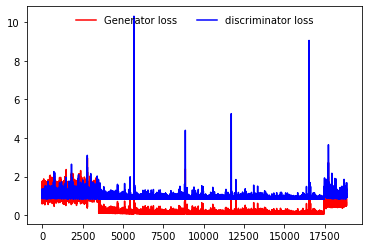

In [ ]:
plt.plot(losses["gen_loss"],'-r',label='Generator loss')
plt.plot(losses["disc_loss"],'-b',label='discriminator loss')
leg = plt.legend(loc='upper center',frameon=False,ncol=2)

## Results

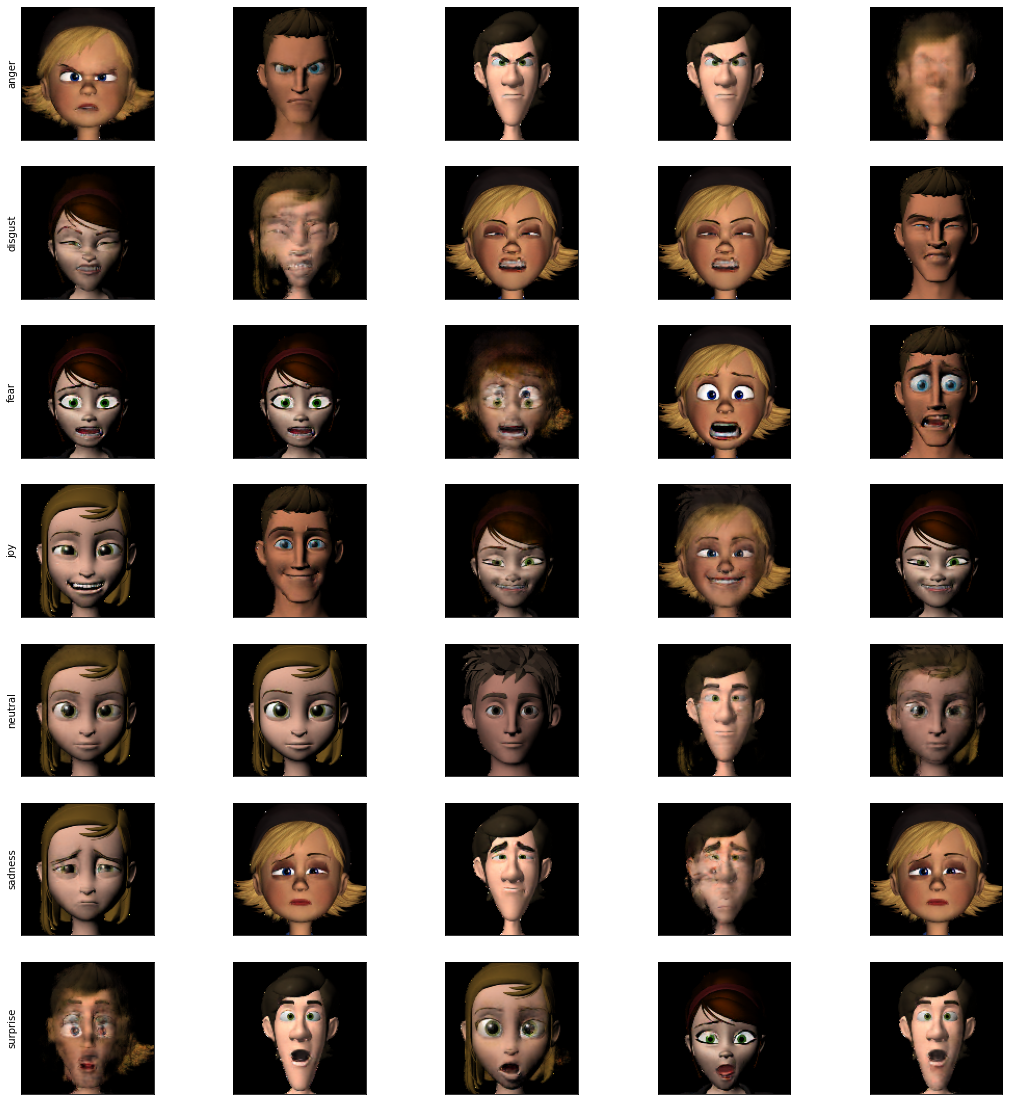

In [ ]:
fig = plt.figure(figsize=(15, 20))

fig.subplots_adjust(left=0.01, right=0.99,  wspace=0.01)

for i in range(7):
    latent_space = np.random.normal(0, 1, (5, latent_dim))
    lbl = np.zeros(shape=(5,7))
    lbl[:,i] = np.random.normal(0,1)
    fake = decoder.predict([latent_space,lbl])
    for j in range(5):

        ax = fig.add_subplot(7,5, 5*i+j+1)
        img = (0.5*fake[j,:,:,:]+0.5)
        img = np.array(img)
        ax.imshow(img)
        ax.set_yticks([])
        ax.set_xticks([])
        if(j==0):
            ax.set_ylabel(affects[i])

In [ ]:
encoder.save("encoder_model.h5")
encoder.save_weights("encoder_weights.h5")
decoder.save("decoder_model.h5")
decoder.save_weights("decoder_weights.h5")
generator.save("generator_model.h5")
generator.save_weights("generator_weights.h5")
discriminator.save('discriminator_model.h5')
discriminator.save_weights('discriminator_weights.h5')

In [ ]:
import glob
def load_test_images(img_dir):
    img_files = glob.glob(img_dir+"/*.png")
    latent_vecs = []
    conditions = []
    imgs = []
    for img_file in img_files:

        img = tf.io.read_file(img_file)
        img =  tf.image.decode_png(img,channels=3)
        imgs.append(img)
        img = tf.cast(img, tf.float32)
        img = normalize(img)
        img = tf.reshape(img,shape=(1,128,128,3))
        lbl  = tf.constant([0,0,0,0,1,0,0])              #Assuming that the test images are in neutral emotion (otherwise change this accordingly)
        lbl = tf.reshape(lbl,shape=(1,7))
        latent_vec,mu,sigma = encoder.predict([img,lbl])
        conditions.append(lbl)
        latent_vecs.append(mu)
    return imgs,latent_vecs,conditions

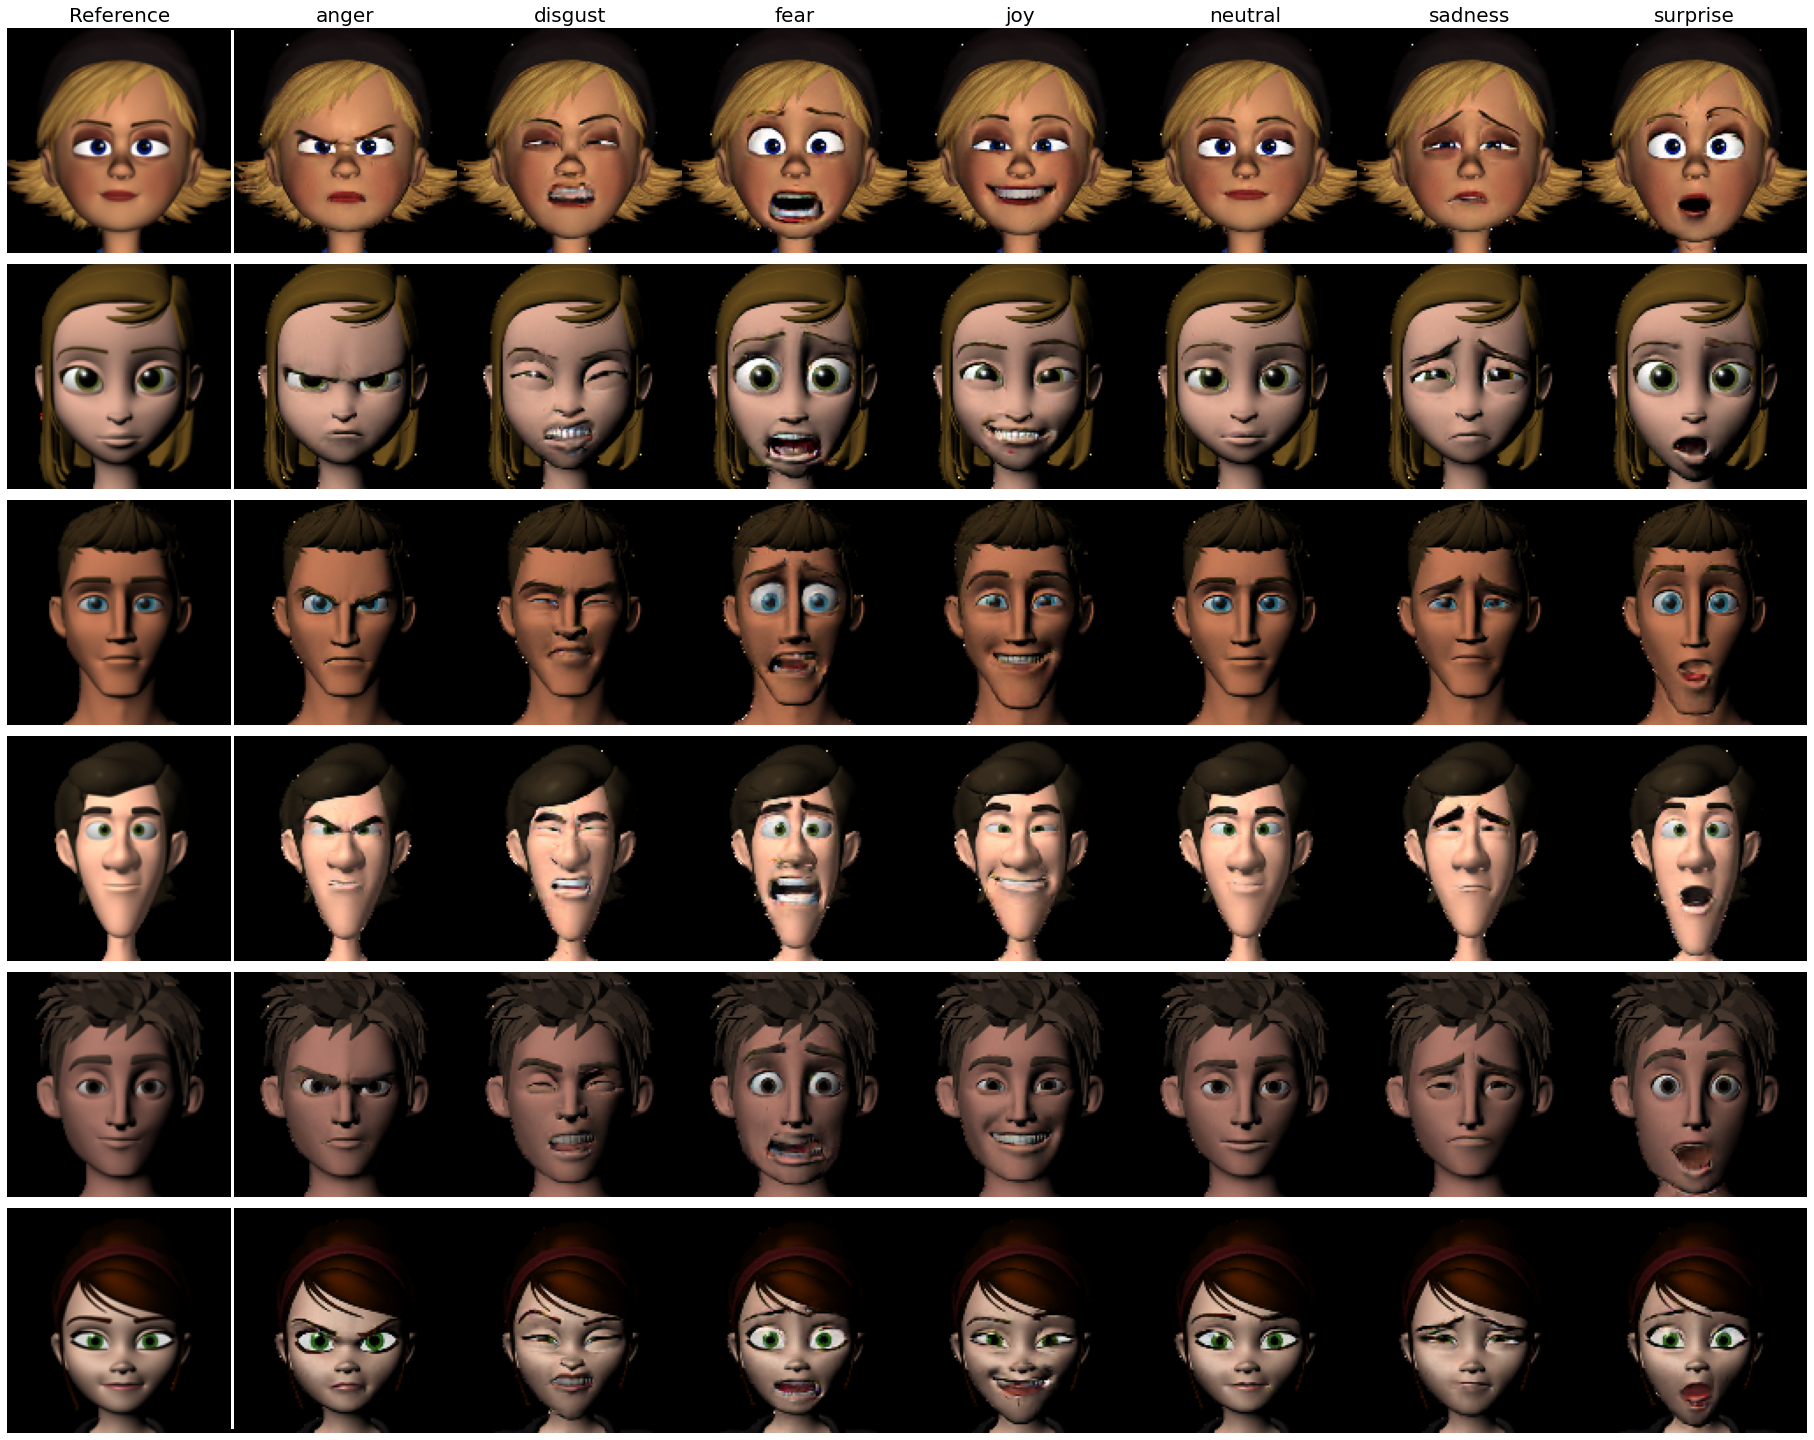

In [ ]:

ref_imgs,latent_vecs,conditions = load_test_images("test")

fig, axes = plt.subplots(6, 8,figsize=(25,20))


for k,ref_img,mu,condition in zip(range(0,6),ref_imgs,latent_vecs,conditions):
    ax = axes[k][0]
    ax.imshow(ref_imgs[k])

    if(k==0):
        ax.set_title("Reference", fontsize=20)
    ax.axis('off')
    for i in range(1,8):
            lbl  = np.zeros(7)
            lbl[i-1] = 1
            lbl = lbl.reshape((1,7))
            fake = decoder.predict([mu,lbl])
            fake = tf.reshape(fake,shape=(128,128,3))
            fake = (0.5*fake+0.5)
            ax = axes[k][i]
            ax.imshow(fake)
            ax.axis('off')
            if(k==0):
                ax.set_title(affects[i-1], fontsize=20)
line = plt.Line2D((.125,.125),(0.01,.98), color="w", linewidth=3)
fig.add_artist(line)
fig.tight_layout(pad=0, w_pad=0, h_pad=0)

## Generating Mixed Expressions

In [ ]:
ref_imgs,latent_vecs,conditions = load_test_images("test")


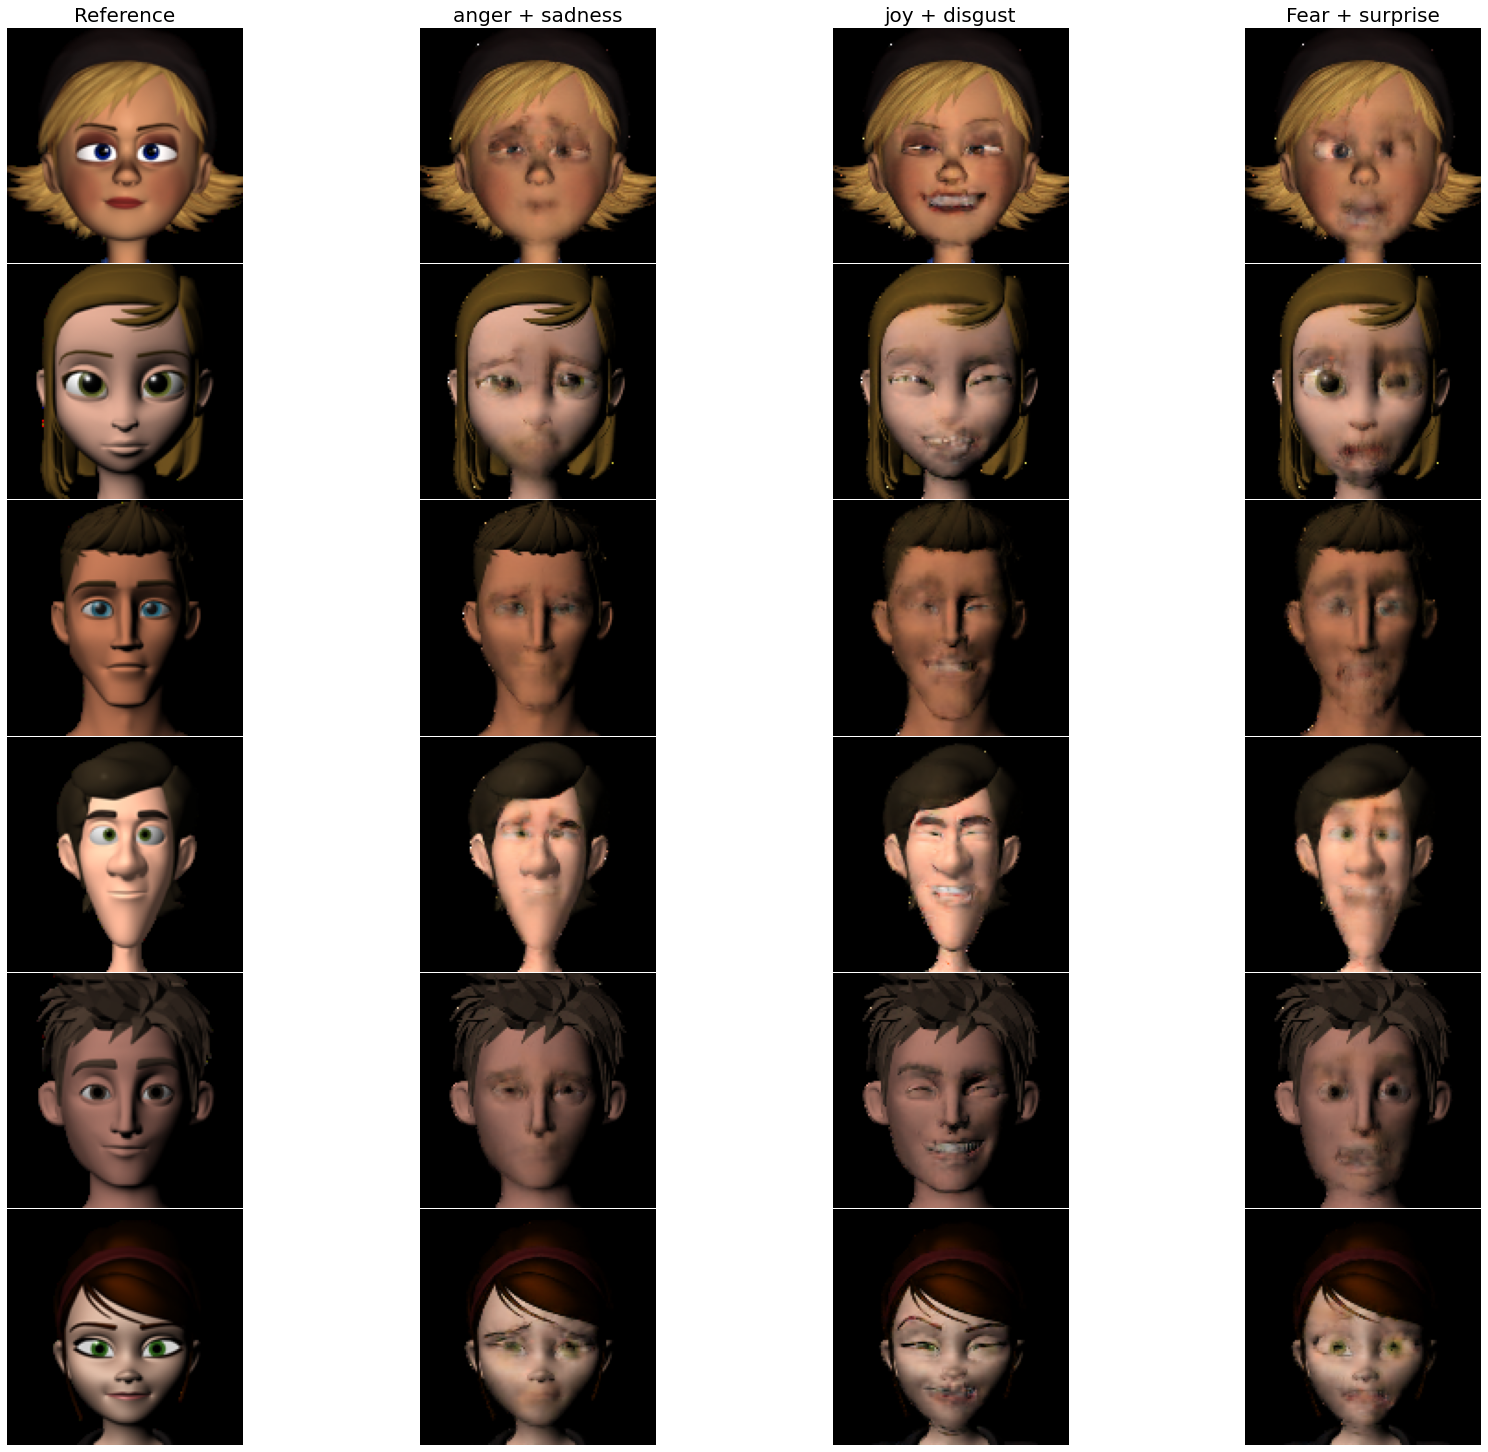

In [ ]:
fig, axes = plt.subplots(6, 4,figsize=(25,20))
mixed_affects = ["anger + sadness","joy + disgust","Fear + surprise"]

lbls  = np.zeros(shape=(3,7))
lbls[0,:] = [0.6,0,0,0,0,0.7,0]   #anger + sadness
lbls[1,:] = [0,0.8,0,1,0,0,0]   #joy + disgust
lbls[2,:] = [0,0,0.8,0,0,0,0.75]   #Fear + surprise


for k,ref_img,mu,condition in zip(range(0,6),ref_imgs,latent_vecs,conditions):
    ax = axes[k][0]
    ax.imshow(ref_imgs[k])

    if(k==0):
        ax.set_title("Reference", fontsize=20)
    ax.axis('off')
    for i in range(1,4):
            lbl = lbls[i-1,:]
            lbl = lbl.reshape((1,7))

            fake = decoder.predict([mu,lbl])
            fake = tf.reshape(fake,shape=(128,128,3))
            fake = (0.5*fake+0.5)
            ax = axes[k][i]
            ax.imshow(fake)
            ax.axis('off')
            if(k==0):
                ax.set_title(mixed_affects[i-1], fontsize=20)
fig.tight_layout(pad=0.1, w_pad=0.1)

## Animation


In [ ]:
from PIL import Image

affect_variation = np.linspace(-1,1,100)
imgs = []
src_idx = 4
lbl  = np.zeros(7)
lbl[src_idx] = 1

for tar_idx in range(7):

    for k in range(10):
        big_img = np.zeros((128,768,3))
        lbl[tar_idx] += 0.1
        lbl[src_idx] -= 0.1
        affect = lbl.reshape((1,7))
        for i,mu in zip(range(len(latent_vecs)),latent_vecs):

                pred = decoder.predict([mu,affect])
                img = tf.reshape(pred,shape=(128,128,3))
                img = (0.5*img+0.5)
                big_img[:,i*128:i*128+128,:] = img
        imgs.append(Image.fromarray(np.uint8(big_img*255)))
    src_idx = tar_idx

In [ ]:
imgs[0].save("FExGAN.gif", format='GIF', append_images=imgs,save_all=True, duration=150, loop=0)